In [2]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load the Iris dataset
data = load_iris()
X = data['data']  # Features: Sepal length, Sepal width, Petal length, Petal width
y = data['target']  # Classes: 0 (Setosa), 1 (Versicolor), 2 (Virginica)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Membership Function (Gaussian)

In [1]:
# def gaussian_membership(x, mean, sigma):
#     """Gaussian membership function."""
#     return np.exp(-0.5 * ((x - mean) / sigma) ** 2)

# # Define membership parameters (means and variances) for each fuzzy set and feature
# membership_params = {
#     "Sepal Length": {"Low": (4.8, 0.4), "Medium": (5.8, 0.5), "High": (6.5, 0.5)},
#     "Sepal Width": {"Low": (2.7, 0.2), "Medium": (2.8, 0.2), "High": (3.5, 0.2)},
#     "Petal Length": {"Low": (1.5, 0.3), "Medium": (4.3, 0.5), "High": (5.5, 0.4)},
#     "Petal Width": {"Low": (0.2, 0.1), "Medium": (1.4, 0.2), "High": (2, 0.2)}
# }

# def compute_memberships(X):
#     """Compute the membership values for each feature in the input."""
#     memberships = []
#     for i, feature_name in enumerate(["Sepal Length", "Sepal Width", "Petal Length", "Petal Width"]):
#         feature_memberships = {}
#         for label, (mean, sigma) in membership_params[feature_name].items():
#             feature_memberships[label] = gaussian_membership(X[:, i], mean, sigma)
#         memberships.append(feature_memberships)
#     return memberships

### Membership Function (Triangular)

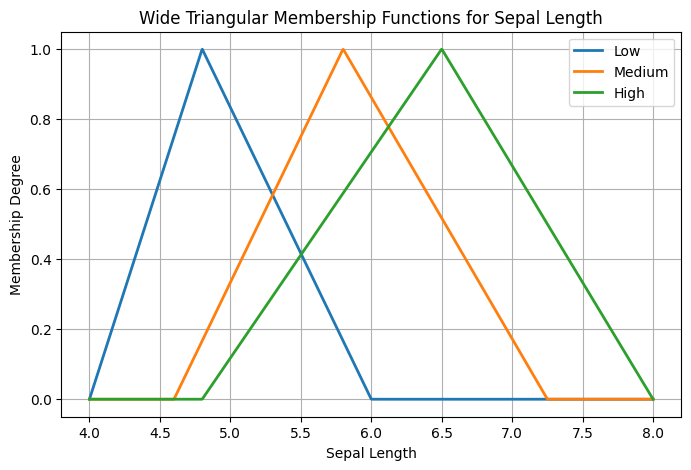

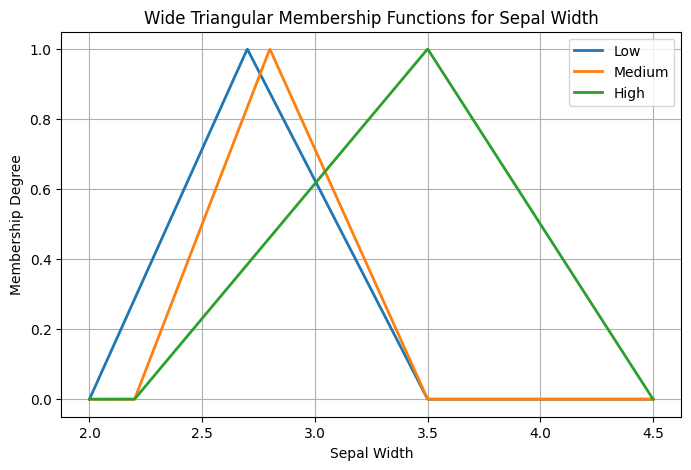

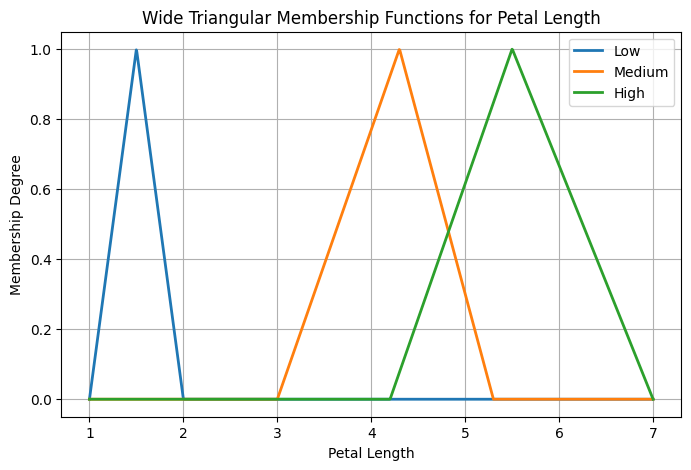

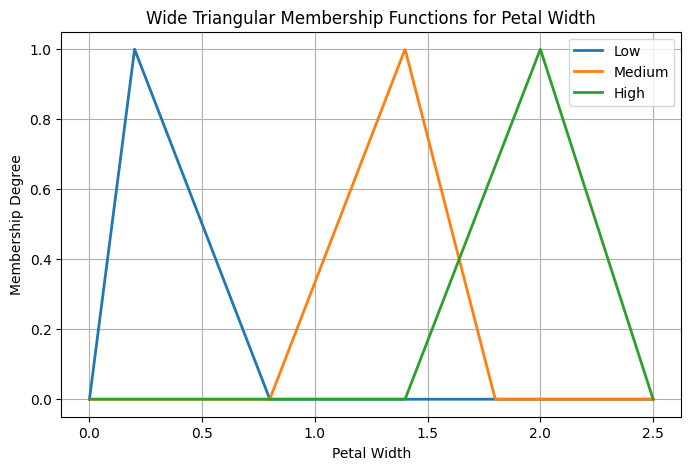

In [3]:
def triangular_membership(x, left, center, right):
    """Triangular membership function."""
    return np.maximum(np.minimum((x - left) / (center - left), (right - x) / (right - center)), 0)

# Update membership parameters for each feature to use triangular boundaries

# - Narrow Intervals
# membership_params = {
#     "Sepal Length": {"Low": (4.3, 4.8, 5.5), "Medium": (5.0, 5.8, 6.5), "High": (6.0, 6.7, 7.1)},
#     "Sepal Width": {"Low": (2.0, 2.5, 3.0), "Medium": (2.7, 3.0, 3.3), "High": (3.0, 3.5, 4.0)},
#     "Petal Length": {"Low": (1.0, 1.5, 3.0), "Medium": (3.0, 4.3, 5.0), "High": (4.5, 5.5, 6.9)},
#     "Petal Width": {"Low": (0.1, 0.2, 0.6), "Medium": (0.5, 1.3, 1.8), "High": (1.5, 1.8, 2.5)}
# }

# - Wide Intervals
membership_params = {
    "Sepal Length": {"Low": (4, 4.8, 6), "Medium": (4.6, 5.8, 7.25), "High": (4.8, 6.5, 8)},
    "Sepal Width": {"Low": (2.0, 2.7, 3.5), "Medium": (2.2, 2.8, 3.5), "High": (2.2, 3.5, 4.5)},
    "Petal Length": {"Low": (1.0, 1.5, 2), "Medium": (3.0, 4.3, 5.3), "High": (4.2, 5.5, 7)},
    "Petal Width": {"Low": (0, 0.2, 0.8), "Medium": (0.8, 1.4, 1.8), "High": (1.4, 2, 2.5)}
}

def compute_memberships(X):
    """Compute the membership values for each feature in the input using triangular membership functions."""
    memberships = []
    for i, feature_name in enumerate(["Sepal Length", "Sepal Width", "Petal Length", "Petal Width"]):
        feature_memberships = {}
        for label, (left, center, right) in membership_params[feature_name].items():
            feature_memberships[label] = triangular_membership(X[:, i], left, center, right)
        memberships.append(feature_memberships)
    return memberships

def plot_membership_functions():
    for feature, params in membership_params.items():
        # Determine range for plotting based on the minimum and maximum of each triangular set
        x_min = min(left for left, center, right in params.values())
        x_max = max(right for left, center, right in params.values())
        x_values = np.linspace(x_min, x_max, 1000)

        plt.figure(figsize=(8, 5))
        for label, (left, center, right) in params.items():
            y_values = triangular_membership(x_values, left, center, right)
            plt.plot(x_values, y_values, label=f'{label}', linewidth=2)

        plt.title(f"Wide Triangular Membership Functions for {feature}")
        plt.xlabel(feature)
        plt.ylabel("Membership Degree")
        plt.legend()
        plt.grid(True)
        plt.show()

# Plot the membership functions for each feature
plot_membership_functions()


### Rules

In [4]:
# Define rules as tuples of conditions and a linear output function
# - Simple rules
rules = [
    # Rules for Setosa
    ({"Sepal Length": "Low", "Petal Width": "Low"}, lambda x: 1.0),
    
    # Rules for Versicolor
    ({"Sepal Length": "Medium", "Petal Length": "Medium"}, lambda x: 2.0),
    
    # Rules for Virginica
    ({"Sepal Length": "High", "Petal Width": "High"}, lambda x: 3.0)
]

# - Complex rules
# rules = [
#     # Rules for Setosa
#     ({"Sepal Length": "Low", "Sepal Width": "High", "Petal Length": "Low", "Petal Width": "Low"}, lambda x: 1.0),
    
#     # Rules for Versicolor
#     ({"Sepal Length": "Medium", "Sepal Width": "Low", "Petal Length": "Medium", "Petal Width": "Medium"}, lambda x: 2.0),
    
#     # Rules for Virginica
#     ({"Sepal Length": "High", "Sepal Width": "Medium", "Petal Length": "High", "Petal Width": "High"}, lambda x: 3.0),
# ]

### Classification Logic

In [5]:
# Minimum intersection operator
def compute_firing_strengths(memberships, rule):
    """Compute the firing strength of a rule based on input memberships using minimum."""
    firing_strength = 1.0  # Initialize firing strength as 1 (neutral for minimum calculation)
    for feature, fuzzy_set in rule.items():
        feature_idx = ["Sepal Length", "Sepal Width", "Petal Length", "Petal Width"].index(feature)
        firing_strength = min(firing_strength, memberships[feature_idx][fuzzy_set])
    return firing_strength
    
# Multiplication intersection operator
# def compute_firing_strengths(memberships, rule):
#     """Compute the firing strength of a rule based on input memberships."""
#     firing_strength = 1.0
#     for feature, fuzzy_set in rule.items():
#         feature_idx = ["Sepal Length", "Sepal Width", "Petal Length", "Petal Width"].index(feature)
#         firing_strength *= memberships[feature_idx][fuzzy_set]
#     return firing_strength

def classify_sample(x):
    """Classify a single sample using the TSK model."""
    memberships = compute_memberships(x.reshape(1, -1))
    outputs = []
    weights = []
    
    for conditions, output_func in rules:
        firing_strength = compute_firing_strengths(memberships, conditions)
        output = output_func(x)
        outputs.append(firing_strength * output)
        weights.append(firing_strength)
    
    # Calculate final class prediction based on weighted average of outputs
    if sum(weights) == 0:
        return 0  # Default to Setosa if no rule fires
    final_output = sum(outputs) / sum(weights)
    
    # Map final output to nearest class
    if final_output < 1.5:
        return 0  # Setosa
    elif final_output < 2.5:
        return 1  # Versicolor
    else:
        return 2  # Virginica

In [6]:
# Predict and evaluate
y_pred = np.array([classify_sample(x) for x in X_test])
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification accuracy: {accuracy * 100:.2f}%")

Classification accuracy: 100.00%


In [7]:
from sklearn.metrics import confusion_matrix

# Predict and evaluate
# Predict and evaluate
y_pred = np.array([classify_sample(x) for x in X_test])
# Define labels
labels = data['target_names']

# Create confusion matrix with labels
conf_matrix = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
conf_matrix_df = pd.DataFrame(conf_matrix, index=labels, columns=labels)

print("Confusion Matrix:")
print(conf_matrix_df)

Confusion Matrix:
            setosa  versicolor  virginica
setosa          19           0          0
versicolor       0          13          0
virginica        0           0         13


### Extra

Trying unsuccessfully to find linear combinations of inputs to outperform the scalar values for Setosa, Versicolor, and Virginica (0, 1, and 2)

In [75]:
import numpy as np
from itertools import product
from sklearn.metrics import accuracy_score

# Define rule templates with placeholders for coefficients
rule_templates = [
    # Rules for Setosa
    ({"Sepal Length": "Low", "Petal Width": "Low"}, lambda x, a, b, c: a * x[0] + b * x[3] + c),
    
    # Rules for Versicolor
    ({"Sepal Length": "Medium", "Petal Length": "Medium"}, lambda x, a, b, c: a * x[0] + b * x[2] + c),
    
    # Rules for Virginica
    ({"Sepal Length": "High", "Petal Width": "High"}, lambda x, a, b, c: a * x[0] + b * x[3] + c)
]

# Define ranges for each coefficient for each rule
# Each rule will have its own set of coefficient ranges
coefficient_ranges = [
    {"a": np.linspace(0.1, 1.0, 3), "b": np.linspace(0.1, 1.0, 3), "c": np.linspace(0.5, 3.0, 3)},  # Setosa rule
    {"a": np.linspace(0.1, 1.0, 3), "b": np.linspace(0.1, 1.0, 3), "c": np.linspace(1.5, 3.5, 3)},  # Versicolor rule
    {"a": np.linspace(0.1, 1.0, 3), "b": np.linspace(0.1, 1.0, 3), "c": np.linspace(2.0, 4.0, 3)}   # Virginica rule
]

# Function to compute firing strengths based on the minimum method
def compute_firing_strengths(memberships, rule):
    firing_strength = 1.0
    for feature, fuzzy_set in rule.items():
        feature_idx = ["Sepal Length", "Sepal Width", "Petal Length", "Petal Width"].index(feature)
        firing_strength = min(firing_strength, memberships[feature_idx][fuzzy_set])
    return firing_strength

# Compute memberships
def compute_memberships(X):
    """Compute the membership values for each feature in the input using triangular functions."""
    memberships = []
    for i, feature_name in enumerate(["Sepal Length", "Sepal Width", "Petal Length", "Petal Width"]):
        feature_memberships = {}
        for label, (left, center, right) in membership_params[feature_name].items():
            feature_memberships[label] = triangular_membership(X[:, i], left, center, right)
        memberships.append(feature_memberships)
    return memberships

# Classification function that uses the current rule set
def classify_sample(x, rule_set):
    memberships = compute_memberships(x.reshape(1, -1))
    outputs = []
    weights = []
    
    for (conditions, output_func) in rule_set:
        firing_strength = compute_firing_strengths(memberships, conditions)
        output = output_func(x)
        outputs.append(firing_strength * output)
        weights.append(firing_strength)
    
    if sum(weights) == 0:
        return 0  # Default to Setosa if no rule fires
    final_output = sum(outputs) / sum(weights)
    
    if final_output < 1.5:
        return 0  # Setosa
    elif final_output < 2.5:
        return 1  # Versicolor
    else:
        return 2  # Virginica

# Evaluate accuracy given a specific set of rule coefficients
def evaluate_rule_set(X_train, y_train, coefficient_sets):
    # Build current rules with the given coefficients
    current_rules = [
        (conditions, lambda x, a=coefficients[0], b=coefficients[1], c=coefficients[2]: output_func(x, a, b, c))
        for (conditions, output_func), coefficients in zip(rule_templates, coefficient_sets)
    ]
    
    # Classify all training samples and compute accuracy
    y_pred = np.array([classify_sample(x, current_rules) for x in X_train])
    return accuracy_score(y_train, y_pred)

# Search for the best coefficients across all rules
best_accuracy = 0
best_coefficients = None

# Iterate over all combinations of coefficients for each rule
for coefficient_combination in product(
        product(coefficient_ranges[0]["a"], coefficient_ranges[0]["b"], coefficient_ranges[0]["c"]),
        product(coefficient_ranges[1]["a"], coefficient_ranges[1]["b"], coefficient_ranges[1]["c"]),
        product(coefficient_ranges[2]["a"], coefficient_ranges[2]["b"], coefficient_ranges[2]["c"])):
    
    # Format the coefficient combination for each rule
    coefficient_sets = [list(combo) for combo in coefficient_combination]
    
    # Evaluate this set of coefficients
    accuracy = evaluate_rule_set(X_train, y_train, coefficient_sets)
    
    # Update the best accuracy and coefficients if the current set is better
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_coefficients = coefficient_sets

print(f"Best accuracy: {best_accuracy:.2f}")
print("Best coefficients for each rule:")
for i, coeffs in enumerate(best_coefficients):
    print(f"Rule {i + 1}: a = {coeffs[0]}, b = {coeffs[1]}, c = {coeffs[2]}")
    
accuracy = evaluate_rule_set(X_test, y_test, best_coefficients)
print(f"Test accuracy: {accuracy:.2f}")


Best accuracy: 0.69
Best coefficients for each rule:
Rule 1: a = 0.1, b = 0.1, c = 0.5
Rule 2: a = 0.1, b = 0.1, c = 1.5
Rule 3: a = 0.1, b = 0.1, c = 2.0
Test accuracy: 0.84
